# 3D Multi-organ Segmentation with SwinUNETR (BTCV Challenge)

- Original data source: https://www.synapse.org/Synapse:syn3193805/wiki/217752
- Kaggle source (raw): https://www.kaggle.com/datasets/lssz1275/abdomen
- Kaggle source (tfrecord): https://www.kaggle.com/datasets/ipythonx/abdomen
- [Original data to tfrecord convertion tools.](https://www.kaggle.com/code/ipythonx/abdomen-nii-to-tfrecord/notebook)

**About Notebook**

We will be modelling 3D multi-organ segmentation task with tfrecord converted dataset.

---

**About Dataset**

As its a multi-organ 3D segmentation task, comes with around 14 classes (background included).

```
Modality: CT Size: 30 3D volumes (24 Training + 6 Testing)
Challenge: BTCV MICCAI Challenge
"labels": {
    "0": "background",
    "1": "spleen",
    "2": "rkid",
    "3": "lkid",
    "4": "gall",
    "5": "eso",
    "6": "liver",
    "7": "sto",
    "8": "aorta",
    "9": "IVC",
    "10": "veins",
    "11": "pancreas",
    "12": "rad",
    "13": "lad"
},
```

In [45]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from medicai.utils.general import hide_warnings
hide_warnings()

import keras

import tensorflow as tf

from medicai.transforms import (
    Compose,
    ScaleIntensityRange,
    CropForeground,
    RandCropByPosNegLabel,
    Spacing,
    Orientation,
    RandShiftIntensity,
    RandRotate90,
    RandFlip
)
from medicai.models import SwinUNETR
from medicai.callbacks import SlidingWindowInferenceCallback

In [47]:
keras.config.set_dtype_policy("mixed_float16")
keras.config.backend(), keras.__version__, tf.__version__

('tensorflow', '3.9.0', '2.19.0')

In [48]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Transformation

Each transformation method require input to be shaped of `depth, height, width, channel` format. In that case, ensure to transpose the target tensors to expected format.

In [13]:
def train_transformation(sample):
    meta = {"affine": sample["image_affine"]} # Since image and label affine are the same
    data = {"image": sample["image"], "label": sample["label"]}
    pipeline = Compose([

        Orientation(keys = ("image", "label"), axcodes = "RAS"),
        Spacing(pixdim=(2.0, 1.5, 1.5), keys=["image", "label"]),
        ScaleIntensityRange(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True
        ),
        CropForeground(
            keys=("image", "label"),
            source_key="image"
        ),
        RandCropByPosNegLabel(
            keys=("image", "label"),
            spatial_size=[96, 96, 96], 
            pos=1, 
            neg=1, 
            num_samples=1,
        ),
        RandFlip(keys=["image", "label"], spatial_axis=[0], prob=0.1),
        RandFlip(keys=["image", "label"], spatial_axis=[1], prob=0.1),
        RandFlip(keys=["image", "label"], spatial_axis=[2], prob=0.1),
        RandRotate90(keys=["image", "label"], prob=0.1, max_k=3, spatial_axes=(1, 2)),
        RandShiftIntensity(keys=["image"], offsets=0.10, prob=0.50),
    ])
    result = pipeline(data, meta)
    return result.data["image"], result.data["label"]


def val_transformation(sample):
    meta = {"affine": sample["image_affine"]} # Since image and label affine are the same
    data = {"image": sample["image"], "label": sample["label"]}
    pipeline = Compose([
        Orientation(keys = ("image", "label"), axcodes = "RAS"),
        Spacing(pixdim=(2.0, 1.5, 1.5), keys=["image", "label"]),
        ScaleIntensityRange(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True
        ),
        CropForeground(
            keys=("image", "label"),
            source_key="image"
        ),
    ])
    result = pipeline(data, meta)
    return result.data["image"], result.data["label"]


In [ ]:
def rearrange_shape(sample):
    image = sample['image']
    label = sample['label']
    image_affine = sample['image_affine']
    label_affine = sample['label_affine']

    # special case
    image = tf.transpose(image, perm=[2, 1, 0, 3])  # hwdc -> dhwc
    label = tf.transpose(label, perm=[2, 1, 0, 3])  # hwdc -> dhwc
    cols = tf.gather(image_affine, [2, 1, 0], axis=1)  # (whd) -> (dhw)
    image_affine = tf.concat([cols, image_affine[:, 3:]], axis=1)
    cols = tf.gather(label_affine, [2, 1, 0], axis=1)  # (whd) -> (dhw)
    label_affine = tf.concat([cols, label_affine[:, 3:]], axis=1)

    # re-update sample with new / updated tensor
    sample['image'] = image
    sample['label'] = label
    sample['image_affine'] = image_affine
    sample['label_affine'] = label_affine

    return sample

In [14]:
def parse_tfrecord_fn(example_proto):
    feature_description = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "label_raw": tf.io.FixedLenFeature([], tf.string),
        "image_shape": tf.io.FixedLenFeature([3], tf.int64),
        "label_shape": tf.io.FixedLenFeature([3], tf.int64),
        "image_affine": tf.io.FixedLenFeature([16], tf.float32),
        "label_affine": tf.io.FixedLenFeature([16], tf.float32),
        "image_pixdim": tf.io.FixedLenFeature([8], tf.float32),
        "label_pixdim": tf.io.FixedLenFeature([8], tf.float32),
    }
    
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # Decode image and label data
    image = tf.io.decode_raw(example["image_raw"], tf.float32)
    label = tf.io.decode_raw(example["label_raw"], tf.float32)
    
    # Reshape to original dimensions
    image = tf.reshape(image, example["image_shape"])
    label = tf.reshape(label, example["label_shape"])
    image = image[..., None] # hwd -> hwdc
    label = label[..., None] # hwd -> hwdc
    
    # Decode affine matrices
    image_affine = tf.squeeze(tf.reshape(example["image_affine"], (4, 4)))
    label_affine = tf.squeeze(tf.reshape(example["label_affine"], (4, 4)))

    # Decode voxel spacing (pixdim)
    image_pixdim = example["image_pixdim"]
    label_pixdim = example["label_pixdim"]

    return {
        "image": image,
        "label": label,
        "image_affine": image_affine,
        "label_affine": label_affine,
        "image_pixdim": image_pixdim,
        "label_pixdim": label_pixdim
    }

# Dataloader

In [15]:
def load_tfrecord_dataset(tfrecord_pattern, batch_size=1, shuffle=True):
    dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(tfrecord_pattern))
    dataset = dataset.shuffle(buffer_size=50) if shuffle else dataset
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(rearrange_shape, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.map(train_transformation, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(val_transformation, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [16]:
tfrecord_pattern = "2/tfrecords/{}_shard_*.tfrec"

train_ds = load_tfrecord_dataset(
    tfrecord_pattern.format("training"), batch_size=1, shuffle=True
)
val_ds = load_tfrecord_dataset(
    tfrecord_pattern.format("validation"), batch_size=1, shuffle=False
)

Instructions for updating:
Use fn_output_signature instead


In [17]:
x, y = next(iter(train_ds))
x.shape, y.shape

(TensorShape([1, 96, 96, 96, 1]), TensorShape([1, 96, 96, 96, 1]))

In [18]:
import numpy as np

x_temp = x.numpy().squeeze()
y_temp = y.numpy().squeeze()
x_temp.shape, y_temp.shape, np.unique(y_temp)

((96, 96, 96),
 (96, 96, 96),
 array([ 0.,  2.,  4.,  6.,  9., 10., 12.], dtype=float32))

[ 0.  2.  4.  6.  9. 10. 12.]


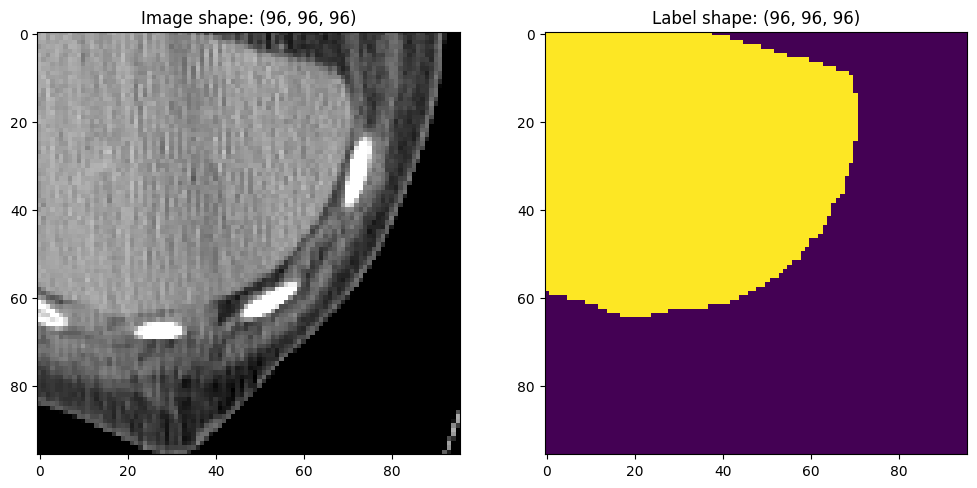

In [19]:
from matplotlib import pyplot as plt

test_image = x_temp
test_mask = y_temp
print(np.unique(y_temp))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(test_image[test_image.shape[0]//2], cmap='gray')
ax1.set_title(f'Image shape: {test_image.shape}')
ax2.imshow(test_mask[test_mask.shape[0]//2])
ax2.set_title(f'Label shape: {test_mask.shape}')
plt.show()

# Model

In [ ]:
num_classes=14
model = SwinUNETR(
    input_shape=(96, 96, 96, 1),
    num_classes=num_classes,
    classifier_activation=None,
)
model.output_shape

In [21]:
from medicai.metrics import SparseDiceMetric
from medicai.losses import SparseDiceCELoss

model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=1e-4,
        weight_decay=1e-5,
    ),
    loss=SparseDiceCELoss(from_logits=True),
    metrics=[
        SparseDiceMetric(
            from_logits=True,
            ignore_empty=True,
            num_classes=num_classes,
            name='dice',
        ),
    ],
    jit_compile=False,
)

In [22]:
from medicai.callbacks import SlidingWindowInferenceCallback

swi_callback_metric = SparseDiceMetric(
    from_logits=True,
    ignore_empty=True,
    num_classes=num_classes,
    name='dice_score'
)

swi_callback = SlidingWindowInferenceCallback(
    model,
    dataset=val_ds, 
    metrics=swi_callback_metric,
    num_classes=num_classes,
    interval=200,
    overlap=0.8,
    roi_size=(96, 96, 96),
    sw_batch_size=4,
    save_path="model.weights.h5"
)

In [ ]:
history = model.fit(
    train_ds, 
    epochs=1000,
    callbacks=[
        swi_callback
    ]
)

Epoch 1/1000


I0000 00:00:1743802861.900078  266143 cuda_dnn.cc:529] Loaded cuDNN version 90300


24/24 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - dice: 0.0479 - loss: 3.7136
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.1081 - loss: 2.4379
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.1169 - loss: 2.1634
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.1186 - loss: 1.9622
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.1453 - loss: 1.8569
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - dice: 0.1588 - loss: 1.7438
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.1170 - loss: 1.7985
Epoch 8/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.1217 - loss: 1.7026
Epoch 9/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.1437 - loss: 1.7320
Epoch 10/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.1445 - loss: 1.6547
Epoch 11/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.1998 - loss: 1.6784
Epoch 12/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.1519 - loss: 1.5647
Epoch 13/1000
24/24 ━━━━━

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


24/24 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - dice: 0.1955 - loss: 1.3932
Epoch 70/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.1739 - loss: 1.2321
Epoch 71/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.2445 - loss: 1.2320
Epoch 72/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.2171 - loss: 1.3066
Epoch 73/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.2396 - loss: 1.2403
Epoch 74/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - dice: 0.2107 - loss: 1.2866
Epoch 75/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.1761 - loss: 1.2137
Epoch 76/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - dice: 0.2539 - loss: 1.1807
Epoch 77/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.2626 - loss: 1.2231
Epoch 78/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - dice: 0.2576 - loss: 1.3573
Epoch 79/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.2065 - loss: 1.1955
Epoch 80/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.2426 - loss: 1.2586
Epoch 81/1000
24/2

Total patch 840: 100%|██████████| 210/210 [07:47<00:00,  2.22s/it]


Epoch 200: Score = 0.5927
New best score! Model saved to model.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3235s 140s/step - dice: 0.5295 - loss: 0.9470
Epoch 201/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.5674 - loss: 0.9054
Epoch 202/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.5117 - loss: 1.0042
Epoch 203/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.5085 - loss: 1.0320
Epoch 204/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.5267 - loss: 0.9529
Epoch 205/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.5359 - loss: 0.9876
Epoch 206/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.5574 - loss: 0.9684
Epoch 207/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.5418 - loss: 0.9518
Epoch 208/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.5355 - loss: 0.9540
Epoch 209/1000
 7/24 ━━━━━━━━━━━━━━━━━━━━ 2:49 10s/step - dice: 0.6992 - loss: 0.9217

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


24/24 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - dice: 0.6005 - loss: 0.9375
Epoch 210/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.6489 - loss: 0.9514
Epoch 211/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.5621 - loss: 0.9396
Epoch 212/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.5212 - loss: 0.9554
Epoch 213/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.5685 - loss: 0.9949
Epoch 214/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.5416 - loss: 0.9393
Epoch 215/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.6197 - loss: 0.9156
Epoch 216/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.5260 - loss: 0.9466
Epoch 217/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.6424 - loss: 0.9124
Epoch 218/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.5850 - loss: 0.9373
Epoch 219/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.5597 - loss: 0.8866
Epoch 220/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.5001 - loss: 1.0084
Epoch 

Total patch 840: 100%|██████████| 210/210 [07:48<00:00,  2.23s/it]


Epoch 400: Score = 0.7602
New best score! Model saved to model.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3188s 138s/step - dice: 0.6793 - loss: 0.8661
Epoch 401/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.6319 - loss: 0.8735
Epoch 402/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.5544 - loss: 1.0194
Epoch 403/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.7071 - loss: 0.8055
Epoch 404/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.7058 - loss: 0.8631
Epoch 405/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.6390 - loss: 0.8605
Epoch 406/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.6736 - loss: 0.8675
Epoch 407/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.6970 - loss: 0.8469
Epoch 408/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.6752 - loss: 0.7772
Epoch 409/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.6354 - loss: 0.8935
Epoch 410/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.6567 - loss: 0.8562
Epoch 411/100

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


24/24 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - dice: 0.7329 - loss: 0.7707
Epoch 418/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.6975 - loss: 0.8596
Epoch 419/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.6919 - loss: 0.8227
Epoch 420/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.5713 - loss: 0.9923
Epoch 421/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.6670 - loss: 0.8946
Epoch 422/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.7118 - loss: 0.8246
Epoch 423/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.6426 - loss: 0.8846
Epoch 424/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.7083 - loss: 0.7955
Epoch 425/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.7561 - loss: 0.7735
Epoch 426/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.7782 - loss: 0.7480
Epoch 427/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.6938 - loss: 0.8283
Epoch 428/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.7266 - loss: 0.7966
Epoch 4

IOStream.flush timed out


24/24 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - dice: 0.7410 - loss: 0.8260
Epoch 443/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.6849 - loss: 0.8747
Epoch 444/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.6486 - loss: 0.8601
Epoch 445/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.7715 - loss: 0.7615
Epoch 446/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.7530 - loss: 0.7914
Epoch 447/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.6169 - loss: 0.9234
Epoch 448/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.6921 - loss: 0.8682
Epoch 449/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.6922 - loss: 0.8265
Epoch 450/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.6913 - loss: 0.7804
Epoch 451/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.7160 - loss: 0.7736
Epoch 452/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.7194 - loss: 0.8237
Epoch 453/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.7407 - loss: 0.7337
Epoch 4

Total patch 840: 100%|██████████| 210/210 [07:45<00:00,  2.21s/it]


Epoch 600: Score = 0.7845
New best score! Model saved to model.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3212s 139s/step - dice: 0.6595 - loss: 0.8625
Epoch 601/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.7212 - loss: 0.7930
Epoch 602/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.7655 - loss: 0.7399
Epoch 603/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.7342 - loss: 0.7882
Epoch 604/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.7802 - loss: 0.7791
Epoch 605/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.6356 - loss: 0.8663
Epoch 606/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.7969 - loss: 0.6451
Epoch 607/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.7907 - loss: 0.7668
Epoch 608/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.7962 - loss: 0.6954
Epoch 609/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.7380 - loss: 0.7968
Epoch 610/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.6207 - loss: 0.9076
Epoch 611/100

IOStream.flush timed out
IOStream.flush timed out


24/24 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - dice: 0.7266 - loss: 0.8067
Epoch 613/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.7099 - loss: 0.8404
Epoch 614/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.7506 - loss: 0.7689
Epoch 615/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.7332 - loss: 0.7741
Epoch 616/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.7448 - loss: 0.7978
Epoch 617/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.8167 - loss: 0.7390
Epoch 618/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.7431 - loss: 0.7896
Epoch 619/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.7456 - loss: 0.7388
Epoch 620/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.7302 - loss: 0.7931
Epoch 621/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.7451 - loss: 0.7417
Epoch 622/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.7757 - loss: 0.7544
Epoch 623/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.6771 - loss: 0.8261
Epoch 6

Total patch 840: 100%|██████████| 210/210 [07:49<00:00,  2.23s/it]


Epoch 800: Score = 0.8024
New best score! Model saved to model.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3220s 140s/step - dice: 0.8170 - loss: 0.7058
Epoch 801/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.8179 - loss: 0.6786
Epoch 802/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.6787 - loss: 0.8446
Epoch 803/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.8036 - loss: 0.7178
Epoch 804/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.7722 - loss: 0.7826
Epoch 805/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - dice: 0.8185 - loss: 0.7121
Epoch 806/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.8012 - loss: 0.6489
Epoch 807/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.8060 - loss: 0.7319
Epoch 808/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.7680 - loss: 0.7610
Epoch 809/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.8068 - loss: 0.6944
Epoch 810/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - dice: 0.8212 - loss: 0.6592
Epoch 811/100

IOStream.flush timed out


24/24 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - dice: 0.7820 - loss: 0.7291
Epoch 818/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - dice: 0.7767 - loss: 0.7313
Epoch 819/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - dice: 0.7675 - loss: 0.7396
Epoch 820/1000
 4/24 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - dice: 0.6817 - loss: 0.7188

## Inference

In [30]:
from medicai.utils.inference import SlidingWindowInference

model.load_weights(
    'model.weights.h5'
)
swi = SlidingWindowInference(
    model,
    num_classes=num_classes,
    roi_size=(96, 96, 96),
    sw_batch_size=4,
    overlap=0.8,
)

In [39]:
x, y = next(iter(val_ds))
x.shape, y.shape, np.unique(y.numpy())

(TensorShape([1, 235, 214, 314, 1]),
 TensorShape([1, 235, 214, 314, 1]),
 array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.],
       dtype=float32))

In [40]:
y_pred = swi(x)
y_pred = y_pred.argmax(-1)
y_pred.shape

Total patch 936: 100%|██████████| 234/234 [08:57<00:00,  2.30s/it]


(1, 235, 214, 314)

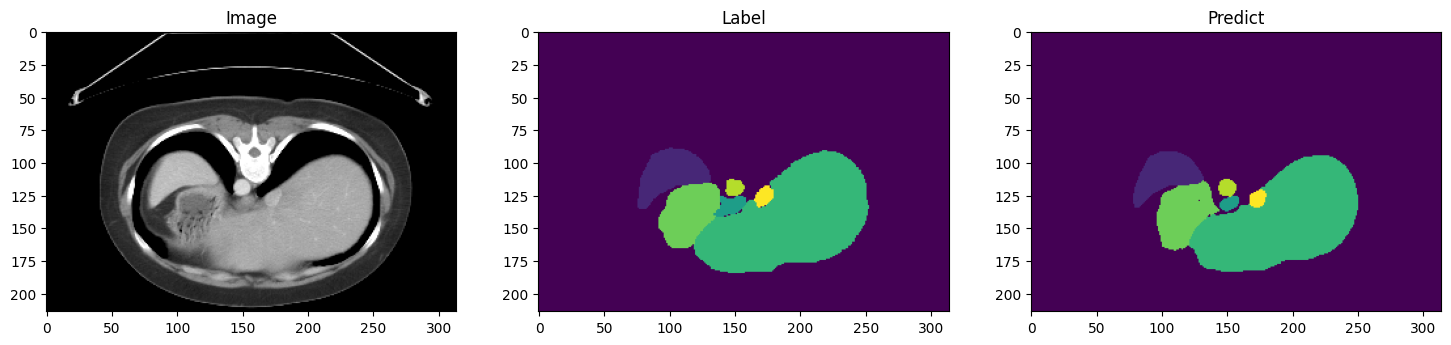

In [44]:
slice_num=208
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(x.numpy()[0, slice_num, :, :, 0], cmap="gray")
ax1.set_title('Image')
ax2.imshow(y.numpy()[0, slice_num, :, :, 0])
ax2.set_title('Label')
ax3.imshow(y_pred[0, slice_num, :, :])
ax3.set_title('Predict')
plt.show()

## Evaluation

In [36]:
dice_metric = SparseDiceMetric(
    from_logits=True,
    ignore_empty=True,
    num_classes=num_classes,
    name='dice_score'
)
dice_metric.reset_state()

for sample in val_ds:
    x, y = sample
    output = swi(x)
    dice_metric.update_state(y, output)

dice_score = dice_metric.result()
print(f"Dice Score: {dice_score.numpy()}")

Total patch 840: 100%|██████████| 210/210 [08:02<00:00,  2.30s/it]


Dice Score: 0.821379542350769
